# Twin-Delayed DDPG

Complete credit goes to this [awesome Deep Reinforcement Learning 2.0 Course on Udemy](https://www.udemy.com/course/deep-reinforcement-learning/) for the code.

# Understanding Implementation
* Because we can't run Kivy on Colab and because we don't have GPUs on our desktop, following is the strategy to train
* Load the sand image and move the coordinates (Vector) in env.Step() for simulating car movement.
* State is captured by cropping a portion of sand image from car's position. And then rotating it the direction of car in such a way that car's orientation is horizontal i.e 0 degrees from x-axis. This state is passed to Actor network
* Action is 2 dimensional. 1st being velocity-x value and 2nd being angle
* To concat action with state for Critic network, we repeat velocity-x value state_dim's height times, as one row and angle as another row. This way critic network input dimension becomes (state_height + 2 * state_width) where state_height & state_width comes from state dimension and 2 comes from action dimension

## Importing the libraries

In [65]:
!pip install kivy

In [0]:
%matplotlib notebook

import os
import time
import random
import numpy as np
import matplotlib.pyplot as plt
import PIL
import matplotlib.patches as patches
import matplotlib.animation as animation

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from collections import deque
from PIL import Image as PILImage

## Step 1: We initialize the Experience Replay memory

In [0]:
class ReplayBuffer(object):

  def __init__(self, max_size=1e6):
    self.storage = []
    self.max_size = max_size
    self.ptr = 0

  def add(self, transition):
    if len(self.storage) == self.max_size:
      self.storage[int(self.ptr)] = transition
      self.ptr = (self.ptr + 1) % self.max_size
    else:
      self.storage.append(transition)

  def sample(self, batch_size):
    ind = np.random.randint(0, len(self.storage), size=batch_size)
    batch_states, batch_next_states, batch_actions, batch_rewards, batch_dones = [], [], [], [], []
    for i in ind: 
      state, next_state, action, reward, done = self.storage[i]
      batch_states.append(np.array(state, copy=False))
      batch_next_states.append(np.array(next_state.cpu(), copy=False))
      batch_actions.append(np.array(action, copy=False))
      batch_rewards.append(np.array(reward, copy=False))
      batch_dones.append(np.array(done, copy=False))
    return np.array(batch_states), np.array(batch_next_states), np.array(batch_actions), np.array(batch_rewards).reshape(-1, 1), np.array(batch_dones).reshape(-1, 1)

In [0]:
# Selecting the device (CPU or GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Step 2: We build one neural network for the Actor model and one neural network for the Actor target

In [0]:
def conv2d_block(in_channels, out_channels):
    return nn.Sequential(
        nn.BatchNorm2d(in_channels),
        nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=(3, 3), padding=0),
        nn.ReLU(),
        nn.BatchNorm2d(out_channels),
        nn.Conv2d(in_channels=out_channels, out_channels=out_channels, kernel_size=(3, 3), padding=0),
        nn.ReLU(),
        nn.BatchNorm2d(out_channels),
        nn.Dropout2d(0.1)
    )

def transition_block(in_channels, out_channels):
    return nn.Sequential(
        nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=(1, 1), padding=0),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.Dropout2d(0.1)
    )

In [0]:
# Creating the architecture of the Neural Network
class Actor(nn.Module):
    def __init__(self, state_dim, action_dim, max_action):
        super(Actor, self).__init__()
        # size after below block = input_size - 2
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=16, kernel_size=(3, 3), padding=0),
            nn.ReLU()
        )
        # size after below block = input_size - 2 - 4
        self.convblock2 = conv2d_block(in_channels=16, out_channels=16)
        # size after below block = (input_size - 2 - 4) / 2
        self.transitionblock = transition_block(in_channels=16, out_channels=10)
        # size after below block = ((input_size - 2 - 4) / 2) - 4
        self.convblock3 = conv2d_block(in_channels=10, out_channels=16)
        # size after below block = ((input_size - 2 - 4) / 2) - 4
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=10, kernel_size=(1, 1), padding=0),
            nn.ReLU(),
            nn.BatchNorm2d(10)
        )
        conv_output_size_h = ((state_dim[0] - 2 - 4) / 2) - 4
        conv_output_size_w = ((state_dim[1] - 2 - 4) / 2) - 4
        linear_input_size = conv_output_size_w * conv_output_size_h * 10
        self.fc = nn.Linear(linear_input_size, action_dim)
        self.max_action = max_action

    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.transitionblock(x)
        x = self.convblock3(x)
        x = self.convblock4(x)
        x = self.fc(x.view(x.size(0), -1))
        x = self.max_action * torch.tanh(x)
        return x

In [71]:
from torchsummary import summary

model = Actor((32,32),2,10).to(device)
summary(model, input_size=(1, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 30, 30]             160
              ReLU-2           [-1, 16, 30, 30]               0
       BatchNorm2d-3           [-1, 16, 30, 30]              32
            Conv2d-4           [-1, 16, 28, 28]           2,320
              ReLU-5           [-1, 16, 28, 28]               0
       BatchNorm2d-6           [-1, 16, 28, 28]              32
            Conv2d-7           [-1, 16, 26, 26]           2,320
              ReLU-8           [-1, 16, 26, 26]               0
       BatchNorm2d-9           [-1, 16, 26, 26]              32
        Dropout2d-10           [-1, 16, 26, 26]               0
           Conv2d-11           [-1, 10, 26, 26]             170
             ReLU-12           [-1, 10, 26, 26]               0
        MaxPool2d-13           [-1, 10, 13, 13]               0
        Dropout2d-14           [-1, 10,

## Step 3: We build two neural networks for the two Critic models and two neural networks for the two Critic targets

In [0]:
# Creating the architecture of the Neural Network
class Critic(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(Critic, self).__init__()
        # Defining the first Critic neural network
        # size after below block = input_size - 2
        self.c1_convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=16, kernel_size=(3, 3), padding=0),
            nn.ReLU()
        )
        # size after below block = input_size - 2 - 4
        self.c1_convblock2 = conv2d_block(in_channels=16, out_channels=16)
        # size after below block = (input_size - 2 - 4) / 2
        self.c1_transitionblock = transition_block(in_channels=16, out_channels=10)
        # size after below block = ((input_size - 2 - 4) / 2) - 4
        self.c1_convblock3 = conv2d_block(in_channels=10, out_channels=16)
        # size after below block = ((input_size - 2 - 4) / 2) - 4
        self.c1_convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=10, kernel_size=(1, 1), padding=0),
            nn.ReLU(),
            nn.BatchNorm2d(10)
        )
        conv_output_size_h = ((state_dim[0] + action_dim - 2 - 4) / 2) - 4
        conv_output_size_w = ((state_dim[1] - 2 - 4) / 2) - 4
        linear_input_size = conv_output_size_w * conv_output_size_h * 10
        self.c1_fc = nn.Linear(linear_input_size, 1)

        # Defining the second Critic neural network
        # size after below block = input_size - 2
        self.c2_convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=16, kernel_size=(3, 3), padding=0),
            nn.ReLU()
        )
        # size after below block = input_size - 2 - 4
        self.c2_convblock2 = conv2d_block(in_channels=16, out_channels=16)
        # size after below block = (input_size - 2 - 4) / 2
        self.c2_transitionblock = transition_block(in_channels=16, out_channels=10)
        # size after below block = ((input_size - 2 - 4) / 2) - 4
        self.c2_convblock3 = conv2d_block(in_channels=10, out_channels=16)
        # size after below block = ((input_size - 2 - 4) / 2) - 4
        self.c2_convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=10, kernel_size=(1, 1), padding=0),
            nn.ReLU(),
            nn.BatchNorm2d(10)
        )
        conv_output_size_h = ((state_dim[0] + action_dim - 2 - 4) / 2) - 4
        conv_output_size_w = ((state_dim[1] - 2 - 4) / 2) - 4
        linear_input_size = conv_output_size_w * conv_output_size_h * 10
        self.c2_fc = nn.Linear(linear_input_size, 1)

    def forward(self, x, u):
      xu = torch.cat([x, u], 2)
      # Forward-Propagation on the first Critic Neural Network
      x1 = self.c1_convblock1(xu)
      x1 = self.c1_convblock2(x1)
      x1 = self.c1_transitionblock(x1)
      x1 = self.c1_convblock3(x1)
      x1 = self.c1_convblock4(x1)
      x1 = self.c1_fc(x1.view(x1.size(0), -1))
      # Forward-Propagation on the second Critic Neural Network
      x2 = self.c2_convblock1(xu)
      x2 = self.c2_convblock2(x2)
      x2 = self.c2_transitionblock(x2)
      x2 = self.c2_convblock3(x2)
      x2 = self.c2_convblock4(x2)
      x2 = self.c2_fc(x2.view(x2.size(0), -1))
      return x1, x2

    def Q1(self, x, u):
      xu = torch.cat([x, u], 2)
      x1 = self.c1_convblock1(xu)
      x1 = self.c1_convblock2(x1)
      x1 = self.c1_transitionblock(x1)
      x1 = self.c1_convblock3(x1)
      x1 = self.c1_convblock4(x1)
      x1 = self.c1_fc(x1.view(x1.size(0), -1))
      return x1

In [73]:
model = Critic((32,32),2).to(device)
summary(model, input_size=[(1, 32, 32), (1,2,32)])

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 32, 30]             160
              ReLU-2           [-1, 16, 32, 30]               0
       BatchNorm2d-3           [-1, 16, 32, 30]              32
            Conv2d-4           [-1, 16, 30, 28]           2,320
              ReLU-5           [-1, 16, 30, 28]               0
       BatchNorm2d-6           [-1, 16, 30, 28]              32
            Conv2d-7           [-1, 16, 28, 26]           2,320
              ReLU-8           [-1, 16, 28, 26]               0
       BatchNorm2d-9           [-1, 16, 28, 26]              32
        Dropout2d-10           [-1, 16, 28, 26]               0
           Conv2d-11           [-1, 10, 28, 26]             170
             ReLU-12           [-1, 10, 28, 26]               0
        MaxPool2d-13           [-1, 10, 14, 13]               0
        Dropout2d-14           [-1, 10,

## Steps 4 to 15: Training Process

In [0]:
# Building the whole Training Process into a class

class TD3(object):
  
  def __init__(self, state_dim, action_dim, max_action):
    self.max_action = torch.Tensor(max_action).to(device)
    self.actor = Actor(state_dim, action_dim, self.max_action).to(device)
    self.actor_target = Actor(state_dim, action_dim, self.max_action).to(device)
    self.actor_target.load_state_dict(self.actor.state_dict())
    self.actor_optimizer = torch.optim.Adam(self.actor.parameters())
    self.critic = Critic(state_dim, action_dim).to(device)
    self.critic_target = Critic(state_dim, action_dim).to(device)
    self.critic_target.load_state_dict(self.critic.state_dict())
    self.critic_optimizer = torch.optim.Adam(self.critic.parameters())
    
  def select_action(self, state):
    #state = torch.Tensor(state.unsqueeze(0)).to(device)
    state = state.unsqueeze(0)
    return self.actor(state).cpu().data.numpy().flatten()

  def expand_action(self, action, state_dim):
    vel = torch.stack([action[:,0]]*state_dim)
    vel = vel.T # (bsize,s_size)
    vel = vel.unsqueeze(1).unsqueeze(1) # (bsize, 1, 1, s_size)

    ang = torch.stack([action[:,1]]*state_dim)
    ang = ang.T # (bsize,s_size)
    ang = ang.unsqueeze(1).unsqueeze(1) # (bsize, 1, 1, s_size)

    return torch.cat([vel,ang], 2)

  def train(self, replay_buffer, iterations, batch_size=100, discount=0.99, tau=0.005, policy_noise=0.2, noise_clip=0.5, policy_freq=2):
    
    for it in range(iterations):
      
      # Step 4: We sample a batch of transitions (s, s’, a, r) from the memory
      batch_states, batch_next_states, batch_actions, batch_rewards, batch_dones = replay_buffer.sample(batch_size)
      state = torch.Tensor(batch_states).to(device)
      next_state = torch.Tensor(batch_next_states).to(device)
      action = torch.Tensor(batch_actions).to(device)
      reward = torch.Tensor(batch_rewards).to(device)
      done = torch.Tensor(batch_dones).to(device)
      
      # Step 5: From the next state s’, the Actor target plays the next action a’
      next_action = self.actor_target(next_state).squeeze(1)

      # Step 6: We add Gaussian noise to this next action a’ and we clamp it in a range of values supported by the environment
      noise = torch.Tensor(batch_actions).data.normal_(0, policy_noise).to(device)
      noise = noise.clamp(-noise_clip, noise_clip)
      next_action[:, 0] = (next_action[:, 0] + noise[:, 0]).clamp(0, self.max_action[0])
      next_action[:, 1] = (next_action[:, 1] + noise[:, 1]).clamp(-self.max_action[1], self.max_action[1])

      # Step 6.1: Because we want to append action of dim=[batch_size,] to state of dim=[batch_size,1,32,32]
      #           We expand action to this dim=[batch_size,1,1,32] and then concat it with state
      next_action = self.expand_action(next_action, batch_states.shape[-1])
      action = self.expand_action(action, batch_states.shape[-1])

      # Step 7: The two Critic targets take each the couple (s’, a’) as input and return two Q-values Qt1(s’,a’) and Qt2(s’,a’) as outputs
      target_Q1, target_Q2 = self.critic_target(next_state, next_action)
      
      # Step 8: We keep the minimum of these two Q-values: min(Qt1, Qt2)
      target_Q = torch.min(target_Q1, target_Q2)
      
      # Step 9: We get the final target of the two Critic models, which is: Qt = r + γ * min(Qt1, Qt2), where γ is the discount factor
      target_Q = reward + ((1 - done) * discount * target_Q).detach()
      
      # Step 10: The two Critic models take each the couple (s, a) as input and return two Q-values Q1(s,a) and Q2(s,a) as outputs
      current_Q1, current_Q2 = self.critic(state, action)
      
      # Step 11: We compute the loss coming from the two Critic models: Critic Loss = MSE_Loss(Q1(s,a), Qt) + MSE_Loss(Q2(s,a), Qt)
      critic_loss = F.mse_loss(current_Q1, target_Q) + F.mse_loss(current_Q2, target_Q)
      
      # Step 12: We backpropagate this Critic loss and update the parameters of the two Critic models with a SGD optimizer
      self.critic_optimizer.zero_grad()
      critic_loss.backward()
      self.critic_optimizer.step()
      
      # Step 13: Once every two iterations, we update our Actor model by performing gradient ascent on the output of the first Critic model
      if it % policy_freq == 0:
        q1_action = self.actor(state)
        q1_action = q1_action.squeeze(1)
        q1_action = self.expand_action(q1_action, state.shape[-1])
        actor_loss = -self.critic.Q1(state, q1_action).mean()
        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        self.actor_optimizer.step()
        
        # Step 14: Still once every two iterations, we update the weights of the Actor target by polyak averaging
        for param, target_param in zip(self.actor.parameters(), self.actor_target.parameters()):
          target_param.data.copy_(tau * param.data + (1 - tau) * target_param.data)
        
        # Step 15: Still once every two iterations, we update the weights of the Critic target by polyak averaging
        for param, target_param in zip(self.critic.parameters(), self.critic_target.parameters()):
          target_param.data.copy_(tau * param.data + (1 - tau) * target_param.data)
  
  # Making a save method to save a trained model
  def save(self, filename, directory):
    torch.save(self.actor.state_dict(), '%s/%s_actor.pth' % (directory, filename))
    torch.save(self.critic.state_dict(), '%s/%s_critic.pth' % (directory, filename))
  
  # Making a load method to load a pre-trained model
  def load(self, filename, directory):
    self.actor.load_state_dict(torch.load('%s/%s_actor.pth' % (directory, filename)))
    self.critic.load_state_dict(torch.load('%s/%s_critic.pth' % (directory, filename)))

## We set the parameters

In [0]:
env_name = "AutoDrivingCarModels" # Name of a environment (set it to any Continous environment you want)
seed = 0 # Random seed number
start_timesteps = 1e4 # Number of iterations/timesteps before which the model randomly chooses an action, and after which it starts to use the policy network
eval_freq = 5e4 # How often the evaluation step is performed (after how many timesteps)
max_timesteps = 5e5 # Total number of iterations/timesteps
save_models = True # Boolean checker whether or not to save the pre-trained model
expl_noise = 0.1 # Exploration noise - STD value of exploration Gaussian noise
batch_size = 100 # Size of the batch
discount = 0.99 # Discount factor gamma, used in the calculation of the total discounted reward
tau = 0.005 # Target network update rate
policy_noise = 0.2 # STD of Gaussian noise added to the actions for the exploration purposes
noise_clip = 0.5 # Maximum value of the Gaussian noise added to the actions (policy)
policy_freq = 2 # Number of iterations to wait before the policy network (Actor model) is updated

## We create a file name for the two saved models: the Actor and Critic models

In [76]:
file_name = "%s_%s_%s" % ("T3D", env_name, str(seed))
print ("---------------------------------------")
print ("Settings: %s" % (file_name))
print ("---------------------------------------")

---------------------------------------
Settings: T3D_AutoDrivingCarModels_0
---------------------------------------


## We create a folder inside which will be saved the trained models

In [0]:
if not os.path.exists("./results"):
  os.makedirs("./results")
if save_models and not os.path.exists("./pytorch_models"):
  os.makedirs("./pytorch_models")

# Download Image

In [0]:
!wget -O MASK1.png https://drive.google.com/uc\?export\=view\&id\=1eHsgsEdvdUMZjSR5XUhA2kFgdPK3qSN3

In [0]:
%matplotlib inline

from PIL import Image, ImageOps
import matplotlib.markers as mmarkers

def center_crop_img(img, x, y, crop_size):
  max_x, max_y = img.size
  pad_left, pad_right, pad_bottom, pad_top = 0, 0, 0, 0
  start_x = x - int(crop_size/2)
  start_y = y - int(crop_size/2)
  end_x = x + int(crop_size/2)
  end_y = y + int(crop_size/2)
  if start_x < 0:
      pad_left = -start_x
      start_x = 0
  if end_x >= max_x:
      pad_right = end_x - max_x
  if start_y < 0:
      pad_top = -start_y
      start_y = 0
  if end_y >= max_y:
      pad_bottom = end_y - max_y
  padding = (int(pad_left), int(pad_top), int(pad_right), int(pad_bottom))
  new_img = ImageOps.expand(img, padding, fill=255)
  crop_img = new_img.crop((start_x, start_y, start_x+crop_size, start_y+crop_size))

  return crop_img

def rotate_img(img, angle):
  im1 = img.convert('RGBA')
  rot = im1.rotate(angle)
  # a white image same size as rotated image
  fff = Image.new('RGBA', rot.size, (255,)*4)
  # create a composite image using the alpha layer of rot as a mask
  return Image.composite(rot, fff, rot).convert('L')

def show_img(ax, img, title=""):
  np_img = np.asarray(img)/255
  np_img = np_img.astype(int)
  ax.imshow(np_img, cmap='gray', vmin=0, vmax=1)
  if title != "":
    ax.set_title(title)

## We create the environment

In [0]:
%matplotlib inline

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T

import matplotlib.patches as patches
import matplotlib.animation as animation
import matplotlib.markers as mmarkers

from PIL import Image as PILImage
from kivy.vector import Vector

class CarEnv(object):
    def __init__(self):
        img = PILImage.open("MASK1.png").convert('L')
        self.sand = np.asarray(img)/255
        self.sand = self.sand.astype(int)
        self.max_y, self.max_x = self.sand.shape
        self.pos = Vector(int(self.max_x/2), int(self.max_y/2))
        self.angle = Vector(0,10).angle(self.pos)
        self.rel_pos = Vector(0,0)
        self.max_angle = 10
        self.min_velocity = 0.5
        self.max_velocity = 10
        self.max_action = [self.max_velocity, self.max_angle]
        self.crop_size = 100
        self.goal_iter = 0
        self.goals = [Vector(1420, 38), Vector(9, 575)]
        self.last_distance = 0
        self.state_dim = (32, 32)
        self.action_dim = (2,)
        self._max_episode_steps = 2000
      
    def seed(self, seed):
        pass
    
    def reset(self):
        on_sand = True
        while on_sand:
          self.pos.x = np.random.randint(low=0, high=self.max_x-5)
          self.pos.y = np.random.randint(low=0, high=self.max_y-5)
          if self.sand[int(self.pos.y),int(self.pos.x)] <= 0:
            on_sand = False
        self.angle = Vector(0,10).angle(self.pos)
        return self.get_state()
    
    def random_action(self):
        vel = np.random.randint(low=self.min_velocity, high=self.max_velocity)
        ang = np.random.randint(low=-self.max_angle, high=self.max_angle)
        return (vel, ang)
    
    def step(self, action):
        vel, ang = action
        self.angle += ang
        reward = 0
        done = False
        current_goal = self.goals[self.goal_iter]
        distance = self.pos.distance(current_goal)
        if self.sand[int(self.pos.y),int(self.pos.x)] > 0:
            self.pos += Vector(vel, 0).rotate(self.angle)
            reward = -1
        else: # otherwise
            self.pos += Vector(vel, 0).rotate(self.angle)
            reward = -0.1
            if distance < self.last_distance:
                reward = 1
        if self.pos.x < 5:
            self.pos.x = 5
            reward = -0.5
            done = True
        if self.pos.x > self.max_x - 5:
            self.pos.x = self.max_x - 5
            reward = -0.5
        if self.pos.y < 5:
            self.pos.y = 5
            reward = -0.5
            done = True
        if self.pos.y > self.max_y - 5:
            self.pos.y = self.max_y - 5
            reward = -0.5
            done = True
        if distance < 25:
            self.goal_iter = (self.goal_iter + 1) % len(self.goals)
            goal = self.goals[self.goal_iter]
            reward = 1
            done = True
        self.last_distance = distance
        return self.get_state(), reward, done
    
    def render(self):
        # Create figure and axes
        fig, ax = plt.subplots(1, 5, figsize=(30, 6))

        # Display the image
        ax[0].imshow(self.sand, cmap='gray', vmin=0, vmax=1)
        # Create a Rectangle patch
        rect = patches.Rectangle(
            (self.pos.x - int(self.crop_size/2), self.pos.y - int(self.crop_size/2)),
            self.crop_size, self.crop_size,
            linewidth=1, edgecolor='r', facecolor='none'
        )
        # Add the patch to the Axes
        ax[0].add_patch(rect)
        ax[0].set_title("x=%d,y=%d,angle=%d" % (self.pos.x, self.pos.y, self.angle))
        
        marker = mmarkers.MarkerStyle(marker="$ \\rightarrow$")
        marker._transform = marker.get_transform().rotate_deg(self.angle)
        ax[0].scatter(self.pos.x, self.pos.y, s=50, c='red', marker=marker)
        self.get_state(ax).cpu().numpy()
        plt.show()
        
    def get_state(self, ax=None):
        resize = T.Compose([T.ToPILImage(),
                            T.Resize(self.state_dim[0], interpolation=Image.CUBIC),
                            T.ToTensor()])
        
        img = Image.open("MASK1.png").convert('L')

        crop_img = center_crop_img(img, self.pos.x, self.pos.y, self.crop_size*3)
        if ax is not None:
          show_img(ax[1], crop_img, "large crop")

        r_img = rotate_img(crop_img, -self.angle)
        if ax is not None:
          show_img(ax[2], r_img, "rotated crop")

        r_img_x, r_img_y = r_img.size
        crop_img = center_crop_img(r_img, int(r_img_x/2), int(r_img_y/2), self.crop_size)
        if ax is not None:
          show_img(ax[3], crop_img, "final crop")

        np_img = np.asarray(crop_img)/255
        np_img = np_img.astype(int)
        screen = np.ascontiguousarray(np_img, dtype=np.float32) 
        screen = torch.from_numpy(screen)
        screen = resize(screen)
        if ax is not None:
            np_img = screen.squeeze(0).numpy()
            np_img = np_img.astype(int)
            ax[4].imshow(np_img, cmap='gray', vmin=0, vmax=1)
            marker = mmarkers.MarkerStyle(marker="$ \\rightarrow$")
            ax[4].scatter(self.state_dim[0]/2, self.state_dim[1]/2, s=100, c='red', marker=marker)
            ax[4].set_title("final resized img")
        return screen.to(device)

# Visualizing Environment

Here we crop large portion of image from postion x,y. Then rotate it and then crop it again to required size. Then resize it to required final size

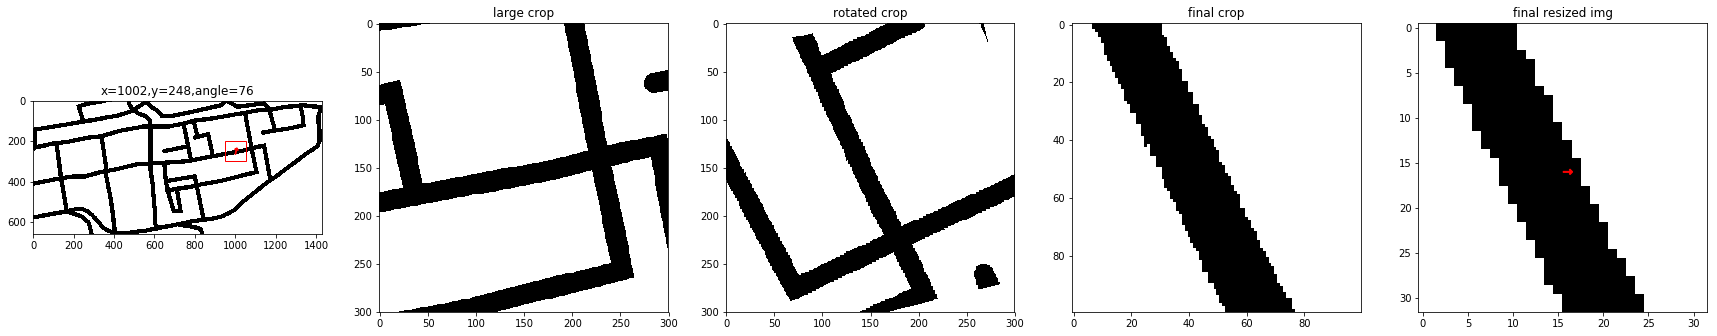

In [105]:
env = CarEnv()
env.reset()
env.render()

# Small animation to understand env.step

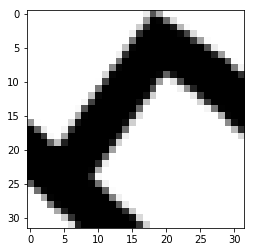

In [95]:
%matplotlib inline

import numpy as np
from matplotlib import pyplot as plt
from IPython.display import clear_output
from time import sleep

plt.figure()
env = CarEnv()
env.reset()
for i in range(20):
    img = env.get_state().cpu().squeeze(0).numpy()
    plt.imshow(img, cmap='gray', animated=True, vmin=0, vmax=1)
    plt.show()
    sleep(0.2)
    clear_output(wait=True)
    vel = np.random.randint(low=0.5, high=5)
    angle = np.random.randint(low=-10, high=+10)
    env.step((vel, angle))


## We set seeds and we get the necessary information on the states and actions in the chosen environment

In [0]:
env.seed(seed)
torch.manual_seed(seed)
np.random.seed(seed)
state_dim = env.state_dim
action_dim = env.action_dim[0]
max_action = env.max_action

# Understanding Environment

* Action Space:
  - Action Space is of 2 dims. With first value (velocity) ranging from 0.5 to 10. And second value (angle) ranging from -10 to +10


## We create the policy network (the Actor model)

In [0]:
policy = TD3(state_dim, action_dim, max_action)

[link text](https://)## We create the Experience Replay memory

In [0]:
replay_buffer = ReplayBuffer()

## We make a function that evaluates the policy by calculating its average reward over 10 episodes

In [109]:
obs = env.reset()
action = policy.select_action(obs)
new_obs, reward, done,  = env.step(action)
print(obs.shape, new_obs.shape, action, reward, done)

(torch.Size([1, 32, 32]), torch.Size([1, 32, 32]), array([1.8616898, 1.95614  ], dtype=float32), -0.1, False)


In [0]:
def evaluate_policy(policy, eval_episodes=10):
  avg_reward = 0.
  for _ in range(eval_episodes):
    obs = env.reset()
    done = False
    episode_timesteps = 0
    while not done:
      action = policy.select_action(obs)
      obs, reward, done = env.step(action)
      episode_timesteps += 1
      avg_reward += reward
      if episode_timesteps + 1 == env._max_episode_steps:
        done = True

  avg_reward /= eval_episodes
  print ("---------------------------------------")
  print ("Average Reward over the Evaluation Step: %f" % (avg_reward))
  print ("---------------------------------------")
  return avg_reward

## We define a list where all the evaluation results over 10 episodes are stored

In [0]:
evaluations = [] # evaluate_policy(policy, eval_episodes=1)]

## We create a new folder directory in which the final results (videos of the agent) will be populated

In [0]:
def mkdir(base, name):
    path = os.path.join(base, name)
    if not os.path.exists(path):
        os.makedirs(path)
    return path
work_dir = mkdir('exp', 'brs')
monitor_dir = mkdir(work_dir, 'monitor')
max_episode_steps = env._max_episode_steps
save_env_vid = False
if save_env_vid:
  env = wrappers.Monitor(env, monitor_dir, force = True)
  env.reset()

## We initialize the variables

In [0]:
total_timesteps = 0
timesteps_since_eval = 0
episode_num = 0
done = True
t0 = time.time()

## Training

In [0]:
import time

max_timesteps = 500000
start_time = time.time()
# We start the main loop over 500,000 timesteps
while total_timesteps < max_timesteps:
  
  # If the episode is done
  if done:

    # If we are not at the very beginning, we start the training process of the model
    if total_timesteps != 0:
      print("Total Timesteps: {} Episode Num: {} Episode Len: {} Reward: {} Time Taken: {} secs".format(
              total_timesteps, episode_num, episode_timesteps,
              episode_reward, time.time() - start_time))
      policy.train(replay_buffer, episode_timesteps, batch_size, discount, tau, policy_noise, noise_clip, policy_freq)
      start_time = time.time()

    # We evaluate the episode and we save the policy
    if timesteps_since_eval >= eval_freq:
      timesteps_since_eval %= eval_freq
      evaluations.append(evaluate_policy(policy))
      policy.save(file_name, directory="./pytorch_models")
      np.save("./results/%s" % (file_name), evaluations)
      start_time = time.time()
    
    # When the training step is done, we reset the state of the environment
    obs = env.reset()
    
    # Set the Done to False
    done = False
    
    # Set rewards and episode timesteps to zero
    episode_reward = 0
    episode_timesteps = 0
    episode_num += 1
  
  # Before 10000 timesteps, we play random actions
  if total_timesteps < start_timesteps:
    action = env.random_action()
  else: # After 10000 timesteps, we switch to the model
    action = policy.select_action(obs)
    # If the explore_noise parameter is not 0, we add noise to the action and we clip it
    if expl_noise != 0:
      action = (action + np.random.normal(0, expl_noise, size=env.action_dim)).clip(-env.max_angle, env.max_angle)
  
  # The agent performs the action in the environment, then reaches the next state and receives the reward
  new_obs, reward, done = env.step(action)

  
  # We check if the episode is done
  #done_bool = 0 if episode_timesteps + 1 == env._max_episode_steps else float(done)
  if episode_timesteps + 1 == env._max_episode_steps: done = True
  done_bool = float(done)
  
  # We increase the total reward
  episode_reward += reward
  # We store the new transition into the Experience Replay memory (ReplayBuffer)
  replay_buffer.add((obs.cpu(), new_obs.cpu(), action, reward, done_bool))

  # We update the state, the episode timestep, the total timesteps, and the timesteps since the evaluation of the policy
  obs = new_obs
  episode_timesteps += 1
  total_timesteps += 1
  timesteps_since_eval += 1

# We add the last policy evaluation to our list of evaluations and we save our model
evaluations.append(evaluate_policy(policy))
if save_models: policy.save("%s" % (file_name), directory="./pytorch_models")
np.save("./results/%s" % (file_name), evaluations)

Total Timesteps: 210 Episode Num: 1 Episode Len: 210 Reward: -153.3 Time Taken: 3.30522799492 secs
Total Timesteps: 387 Episode Num: 2 Episode Len: 177 Reward: -119.3 Time Taken: 2.74998497963 secs
Total Timesteps: 660 Episode Num: 3 Episode Len: 273 Reward: -180.4 Time Taken: 4.24683499336 secs
Total Timesteps: 719 Episode Num: 4 Episode Len: 59 Reward: 27.8 Time Taken: 0.939138889313 secs
Total Timesteps: 740 Episode Num: 5 Episode Len: 21 Reward: -7.6 Time Taken: 0.344402074814 secs
Total Timesteps: 857 Episode Num: 6 Episode Len: 117 Reward: -93.8 Time Taken: 1.83670687675 secs
Total Timesteps: 1377 Episode Num: 7 Episode Len: 520 Reward: -388.7 Time Taken: 8.06953501701 secs
Total Timesteps: 1379 Episode Num: 8 Episode Len: 2 Reward: 0.5 Time Taken: 0.0470719337463 secs
Total Timesteps: 1430 Episode Num: 9 Episode Len: 51 Reward: -33.6 Time Taken: 0.810391902924 secs
Total Timesteps: 1517 Episode Num: 10 Episode Len: 87 Reward: -76.7 Time Taken: 1.37070083618 secs
Total Timesteps: